## **安装配置**
- 关于：systemq主要定义设备驱动和量子门
- 安装：见[systemq](../../systemq)
- 安装前：**务必**删除干净电脑上**多余的Python或Conda**！！！
- 对于Windows：安装后确保**环境变量**被正确设置，否则提示命令找不到！！！

## **设备调试**

如需编写驱动（可参考dev中其他设备的实现）：

- 设备驱动必须继承自BaseDriver(`from quark.driver import BaseDriver`)
- 所有驱必须实现`open`/`close`/`write`/`read`方法


测试并确保设备驱动***完全无误***：
```python
# 根据设备类型导入设备驱动，如网分
from systemq.dev import NetworkAnalyzer

# 根据设备地址实例化设备
dev = NetworkAnalyzer.Driver('192.168.1.42')
# 打开设备
dev.open()

# 设备写操作，通过setValue（实际调用`write`方法），可操作属性见驱动文件定义的quants列表
dev.setValue('Power', -10)
# 设备读操作，通过getValue（实际调用`read`方法），可操作属性见驱动文件定义的quants列表
dev.getVaule('Power')
```


## **实验示例**

- 按要求启动[**QuarkServer**](../../quark/server/)并注册用户名到指定的cfg表（如不更换用户名或cfg，下次不再需要此操作！）
- 更多范例见[**demo**](../demo/)

### **imports**

In [6]:
import matplotlib.pyplot as plt
import numpy as np

from quark.app import Recipe, s, submit

In [ ]:
# 如果重启server需要重新login，用户名与注册时保持一致
s.login('baqis')

# 更新参数：s.update('gate.Measure.Q0.params.frequency',5.321e9)
# 查询参数：s.query('gate.Measure.Q0.params.frequency')
# 写设备：s.write('AWG.CH1.Offset',0.2)
# 读设备：s.read('AWG.CH1.Offset')

### **open device**

In [ ]:
# 打开设备，在此之前，任务不可执行！
s.start()

'QuarkServer started!'

### **example: S21**

In [ ]:
def S21(qubits: list[str], ctx=None) -> dict:
    cc = [(('Measure', i, ), q) for i, q in enumerate(qubits)]
    return cc


rcp = Recipe('s21', signal='iq_avg')
rcp.circuit = S21

qubits = [f'Q{i}' for i in range(0, 9, 4)]
rcp['qubits'] = tuple(qubits) # 必须为tuple
rcp['freq'] = np.linspace(-5, 5, 101) * 1e6

for q in qubits:
    rcp[f'gate.Measure.{q}.params.frequency'] = rcp['freq'] + \
        s.query(f'gate.Measure.{q}.params.frequency')
    rcp[f'gate.Measure.{q}.default_type'] = 'default'

s21 = submit(rcp.export(), preview=[])
s21.bar(interval=1)

#### circuit in qlisp

In [11]:
cirq = s21.circuit(0)
cirq

[(('Measure', 0), 'Q0'), (('Measure', 1), 'Q4'), (('Measure', 2), 'Q8')]

#### commands sent to device

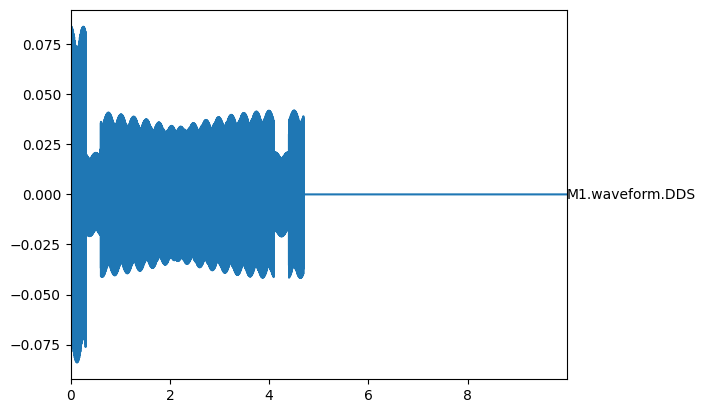

In [ ]:
from quark.app import preview

cmds = s21.step(0)
wfv = preview(cmds['main'], start=0, end=10e-6, srate=5e9)

#### result

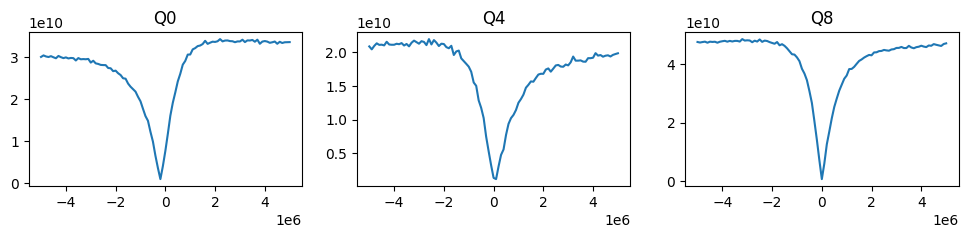

In [16]:
rs = s21.result()
signal = rs['meta']['other']['signal'].split('|')[0]

r = np.asarray(rs['data'][signal])
ax = plt.subplots(1, 3, figsize=(12, 2))[1].flatten()
for i, q in enumerate(qubits):
    fq = rs['meta']['axis']['freq']['def']
    rq = np.abs(r)[:, i]
    ax[i].plot(fq, rq)

    ax[i].set_title(f'{q}')

## **常见问题**
***遇到问题先看错误信息！遇到问题先看错误信息！遇到问题先看错误信息！***
1. 设备没有正常开启？
- 检查`etc.driver.path`是否正确，一般为`systemq/dev`！
- 设备`type`为`remote`时，检查设备名字、`host`和`port`是否和设备的ip和端口匹配！

2. 线路编译错误？
- 检查线路编写是否有误！
- 检查`systemq.lib.gates.__init__`中导入的门模块是否正确，或cfg表中填写的参数是否匹配！

3. 实验没有数据或采集设备显示超时？
- 检查触发设备`shots`设置和采集设备设置是否一致！

4. 波形下发错误？
- 检查设备上的numpy（**大**版本同为1.x.x或2.x.x）和waveforms版本和测量电脑是否一致！